In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import chain
from collections import Counter

In [2]:
# Load data
train = pd.read_csv('../data/train.csv', index_col='ex_id')
val = pd.read_csv('../data/dev.csv', index_col='ex_id')
test = pd.read_csv('../data/test_no_label.csv', index_col='ex_id')

# Load tokenized data
train_data_tokens = pkl.load(open("../data/tokens/train_data_tokens.pkl", "rb"))
val_data_tokens = pkl.load(open("../data/tokens/val_data_tokens.pkl", "rb"))
test_data_tokens = pkl.load(open("../data/tokens/test_data_tokens.pkl", "rb"))
all_train_tokens = list(chain.from_iterable(train_data_tokens))

# Get labels
y_train = train.label.values
y_val = val.label.values
y_test = test.label.values

# Vocab
def build_vocab(all_tokens, threshold):
    c = Counter(all_tokens)
    vocab = [word for word, count in Counter(all_train_tokens).items() if count >= threshold]
    id2token = vocab
    token2id = dict(zip(vocab, range(len(vocab))))
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, 20)

In [3]:
# TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy(doc):
    return doc

tfidf_vec = TfidfVectorizer(lowercase=False, preprocessor=dummy, tokenizer=dummy, vocabulary=token2id)  

X_train_tfidf = tfidf_vec.fit_transform(train_data_tokens)
X_val_tfidf = tfidf_vec.transform(val_data_tokens)
X_test_tfidf = tfidf_vec.transform(test_data_tokens)

---

### Train Latent Factor Model

##### MyAlgo

In [4]:
from surprise import AlgoBase
from surprise import SVD
from surprise import PredictionImpossible

class MyAlgo(SVD):

    def __init__(self, n_factors=25, n_epochs=20, biased=False, 
                 lr_all=.005, reg_all=.1, random_state=None, verbose=False):

        SVD.__init__(self, n_factors=n_factors, n_epochs=n_epochs, 
                     biased=biased, lr_all=lr_all, reg_all=reg_all, 
                     random_state=random_state, verbose=verbose)

    def fit(self, trainset):

        SVD.fit(self, trainset)

        return self

    def estimate(self, u, i):

        known_user = self.trainset.knows_user(u)
        known_item = self.trainset.knows_item(i)

        if known_user and known_item:

            if self.biased:
                est = self.trainset.global_mean
                if known_user:
                    est += self.bu[u]

                if known_item:
                    est += self.bi[i]

                if known_user and known_item:
                    est += np.dot(self.qi[i], self.pu[u])

            else:
                est = np.dot(self.qi[i], self.pu[u])    

        else:
            est = 0
            raise PredictionImpossible('User and item are unknown.')

        return est
    
    def test(self, testset, clip=False, verbose=False):
        predictions = [self.predict(uid,
                                    iid,
                                    r_ui_trans,
                                    clip=clip,
                                    verbose=verbose)
                       for (uid, iid, r_ui_trans) in testset]
        return predictions

##### Construct ALS Dataset

In [5]:
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Get train data
# SELECT user_id, prod_id, rating FROM train WHERE label = 0
train_als = train[(train['label'] == 0)][['user_id', 'prod_id', 'rating']]

# The columns must correspond to user id, item id and ratings (in that order)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_als[['user_id', 'prod_id', 'rating']], reader)

##### Train Model

In [6]:
rank = 25
reg = 0.1

algo = MyAlgo(n_factors=rank, reg_all=reg, biased=True,
              lr_all=0.005, n_epochs=30, verbose=False, random_state=None)

algo.fit(data.build_full_trainset())

# user_factors = algo.pu
# prod_factors = algo.qi

#### Generate rating features & Combine rating features and review features

In [7]:
from scipy.sparse import csr_matrix, coo_matrix, hstack

def combine_features(rating_features, review_features):
    return hstack( [csr_matrix(rating_features), review_features], format='csr' )


def get_rating_features(val, algo):
    testset = list(zip(val['user_id'].values, val['prod_id'].values, val['rating'].values))
    predictions = algo.test(testset)
    pred_rating = []
    is_missing = []
    actual_rating = []
    diff = []
    
    for pred in predictions:
        pred_rating.append(pred.est)
        is_missing.append( int(pred.details['was_impossible']) )
        actual_rating.append(pred.r_ui)
        diff.append(pred.r_ui - pred.est)
    
    rating_features = list(zip(pred_rating, is_missing, actual_rating, diff))

    return rating_features

In [8]:
train_rating_features = get_rating_features(train, algo)
X_train = combine_features(train_rating_features, X_train_tfidf)

val_rating_features = get_rating_features(val, algo)
X_val = combine_features(val_rating_features, X_val_tfidf)

### Logistic Regression

#### Evaluation

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import average_precision_score

def evaluate(model, X, y=y_val):
    y_scores = model.predict_proba(X)[:, 1]
    print('Accuracy: ', model.score(X, y))
    print('AUC: ', roc_auc_score(y, y_scores))
    print('AP: ', average_precision_score(y, y_scores))
    print('\nConfusion Matrix')
    print(confusion_matrix(y, model.predict(X)))
    
#     precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
#     print('Precision: ', precision)
#     print('Recall: ', recall)
    

#### Baseline

In [17]:
lr_0 = LogisticRegression(C=0.4, max_iter=1000)
lr_0.fit(X_train, y_train)
evaluate(lr_0, X=X_val)

Accuracy:  0.7221170443788629
AUC:  0.8633073201237912
AP:  0.32773813310107014

Confusion Matrix
[[22376  9894]
 [   87  3561]]


#### Oversample

In [11]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [12]:
lr_ros = LogisticRegression(C=0.4, max_iter=1000)
lr_ros.fit(X_train_ros, y_train_ros)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
evaluate(lr_ros, X=X_val)

Accuracy:  0.7221170443788629
AUC:  0.856787843897977
AP:  0.31072376517308203

Confusion Matrix
[[22376  9894]
 [   87  3561]]


#### Undersample

In [14]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [15]:
lr_rus = LogisticRegression(C=0.4, max_iter=1000)
lr_rus.fit(X_train_rus, y_train_rus)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
evaluate(lr_rus, X=X_val)

Accuracy:  0.7221170443788629
AUC:  0.8628148844521825
AP:  0.3268212815096027

Confusion Matrix
[[22376  9894]
 [   87  3561]]


---

In [92]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

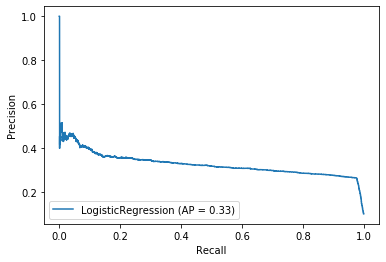

In [93]:
disp = plot_precision_recall_curve(lr_2, X_val, y_val)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y